In [86]:
#import sample data: adult income for classification
#http://archive.ics.uci.edu/ml/index.phpから落としてきた、adultというデータ(ちょっとエクセルで修正)を使ってテストをしてみる。
#前処理めっちゃ重かったのでこれは前処理のみ
import pandas as pd
import numpy as np

df = pd.read_csv('./data/adult/adult.csv', header=0, \
                dtype={'Workclass':object,
                      'Education':object,
                      'Marital_Status':object,
                      'Occupation':object,
                      'Relationship':object,
                      'Race':object,
                      'Sex':object,
                      'Native_country':object,
                      'Income':object})

#まず、欠損値NaNの処理とget_dummiesする。seminarのP04S06_Scoring process-2に従ってデータの前処理をする。


X = df.iloc[:,:-1]
y = df.iloc[:,[-1]]

#check the shape
print('----------------------------------------------------------------------------------------')
print('Raw shape: (%i,%i)' %df.shape)
print('X shape: (%i,%i)' %X.shape)
print('y shape: (%i,%i)' %y.shape)
print('----------------------------------------------------------------------------------------')
print(X.dtypes)
print('----------------------------------------------------------------------------------------')
print('Check the null count of the target variable: %i' % y.isnull().sum())
print('----------------------------------------------------------------------------------------')
#収入が50K$を超える(>50K)を1(正例)として変換
class_mapping = {'>50K':1,'<=50K':0}
y_new = y.copy()
y_new.loc[:,'Income'] = y_new['Income'].map(class_mapping)
print(y_new.groupby(['Income']).size())
X.head(15)
#ちょっとしたNaNの確認
print('----------------------------------------------------------------------------------------')
print(X.iloc[:,[13]].isnull().sum())

----------------------------------------------------------------------------------------
Raw shape: (32561,15)
X shape: (32561,14)
y shape: (32561,1)
----------------------------------------------------------------------------------------
Age                int64
Workclass         object
Fnlwgt             int64
Education         object
Education_num      int64
Marital_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_Per_Week     int64
Native_Country    object
dtype: object
----------------------------------------------------------------------------------------
Check the null count of the target variable: 0
----------------------------------------------------------------------------------------
Income
0    24720
1     7841
dtype: int64
----------------------------------------------------------------------------------------
Native_Country    583
dtype: int64


In [87]:
ohe_columns = ['Workclass','Education','Marital_Status','Occupation','Relationship','Race','Sex','Native_Country']
X_ohe = pd.get_dummies(X, dummy_na=True, columns=ohe_columns)
print('X_ohe shape:(%i,%i)' %X_ohe.shape)

X_ohe shape:(32561,113)


In [88]:
from sklearn.preprocessing import Imputer

#欠損値NaNを平均値(mean)で置換
imp = Imputer(missing_values='NaN',strategy='mean',axis=0)
imp.fit(X_ohe)

#学習済みImputerを適用し、X_newの欠損値を置換
X_ohe_columns = X_ohe.columns.values
X_ohe = pd.DataFrame(imp.transform(X_ohe), columns=X_ohe_columns)

#結果表示
X_ohe.head()

,Age,Fnlwgt,Education_num,Capital_Gain,Capital_Loss,Hours_Per_Week,Workclass_Federal-gov,Workclass_Local-gov,Workclass_Never-worked,Workclass_Private,...,Native_Country_Puerto-Rico,Native_Country_Scotland,Native_Country_South,Native_Country_Taiwan,Native_Country_Thailand,Native_Country_Trinadad&Tobago,Native_Country_United-States,Native_Country_Vietnam,Native_Country_Yugoslavia,Native_Country_nan
0,39.0,77516.0,13.0,2174.0,0.0,40.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,50.0,83311.0,13.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,38.0,215646.0,9.0,0.0,0.0,40.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,53.0,234721.0,7.0,0.0,0.0,40.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,28.0,338409.0,13.0,0.0,0.0,40.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingClassifier

selector = RFE(GradientBoostingClassifier(random_state=1), n_features_to_select=15, step=.05)
selector.fit(X_ohe, y.as_matrix().ravel())

X_fin = X_ohe.loc[:, X_ohe_columns[selector.support_]]
print('X_fin shape:(%i,%i)' % X_fin.shape)
X_fin.head()

X_fin shape:(32561,15)


,Age,Fnlwgt,Education_num,Capital_Gain,Capital_Loss,Hours_Per_Week,Workclass_Self-emp-not-inc,Marital_Status_Married-civ-spouse,Occupation_Exec-managerial,Occupation_Farming-fishing,Occupation_Other-service,Occupation_Prof-specialty,Occupation_Tech-support,Relationship_Wife,Sex_Male
0,39.0,77516.0,13.0,2174.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,50.0,83311.0,13.0,0.0,0.0,13.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,38.0,215646.0,9.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,53.0,234721.0,7.0,0.0,0.0,40.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,28.0,338409.0,13.0,0.0,0.0,40.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


テストデータが別にある(答えつき)ので、そっちを読み込む。

In [90]:
import pandas as pd

# import sample data
# Loan screening data for classification 
df_s = pd.read_csv('./data/adult/adult_test.csv', header=0, \
                dtype={'Workclass':object,
                      'Education':object,
                      'Marital_Status':object,
                      'Occupation':object,
                      'Relationship':object,
                      'Race':object,
                      'Sex':object,
                      'Native_country':object,
                      'Income':object})
X_s = df_s.iloc[:,:-1]
y_s = df_s.iloc[:,[-1]]

print('----------------------------------------------------------------------------------------')
print('Raw shape: (%i,%i)' %df_s.shape)
print('X_s shape: (%i,%i)' %X_s.shape)
print('y_s shape: (%i,%i)' %y_s.shape)
print(X_s.dtypes)

----------------------------------------------------------------------------------------
Raw shape: (16281,15)
X_s shape: (16281,14)
y_s shape: (16281,1)
Age                int64
Workclass         object
Fnlwgt             int64
Education         object
Education_num      int64
Marital_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_Per_Week     int64
Native_Country    object
dtype: object


In [91]:
ohe_columns = ['Workclass','Education','Marital_Status','Occupation','Relationship','Race','Sex','Native_Country']
X_ohe_s = pd.get_dummies(X_s, dummy_na=True, columns=ohe_columns)
print('X_ohe_s shape:(%i,%i)' % X_ohe_s.shape)
X_ohe_s.head()

X_ohe_s shape:(16281,112)


,Age,Fnlwgt,Education_num,Capital_Gain,Capital_Loss,Hours_Per_Week,Workclass_Federal-gov,Workclass_Local-gov,Workclass_Never-worked,Workclass_Private,...,Native_Country_Puerto-Rico,Native_Country_Scotland,Native_Country_South,Native_Country_Taiwan,Native_Country_Thailand,Native_Country_Trinadad&Tobago,Native_Country_United-States,Native_Country_Vietnam,Native_Country_Yugoslavia,Native_Country_nan
0,25,226802,7,0,0,40,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,38,89814,9,0,0,50,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,28,336951,12,0,0,40,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,44,160323,10,7688,0,40,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,18,103497,10,0,0,30,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [92]:
cols_model = set(X_ohe.columns.values)
cols_score = set(X_ohe_s.columns.values)

#モデルにはあったがスコアにはないデータ項目
diff1 = cols_model - cols_score
print('モデルのみに存在する項目: %s' % diff1)

diff2 = cols_score - cols_model
print('スコアのみに存在する項目: %s' % diff2)

モデルのみに存在する項目: {'Native_Country_Holand-Netherlands'}
スコアのみに存在する項目: set()


モデルのみに一個あるので、スコアに付け足す

In [93]:
df_cols_m = pd.DataFrame(None, columns=X_ohe_columns, dtype=float)
#colsの確認
df_cols_m

,Age,Fnlwgt,Education_num,Capital_Gain,Capital_Loss,Hours_Per_Week,Workclass_Federal-gov,Workclass_Local-gov,Workclass_Never-worked,Workclass_Private,...,Native_Country_Puerto-Rico,Native_Country_Scotland,Native_Country_South,Native_Country_Taiwan,Native_Country_Thailand,Native_Country_Trinadad&Tobago,Native_Country_United-States,Native_Country_Vietnam,Native_Country_Yugoslavia,Native_Country_nan


In [94]:
X_ohe_s2 = pd.concat([df_cols_m, X_ohe_s])
print(X_ohe_s2.loc[:,'Native_Country_Holand-Netherlands'].head())
#追加したのがNaNであることの確認
X_ohe_s2.head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: Native_Country_Holand-Netherlands, dtype: float64


,Age,Capital_Gain,Capital_Loss,Education_10th,Education_11th,Education_12th,Education_1st-4th,Education_5th-6th,Education_7th-8th,Education_9th,...,Sex_nan,Workclass_Federal-gov,Workclass_Local-gov,Workclass_Never-worked,Workclass_Private,Workclass_Self-emp-inc,Workclass_Self-emp-not-inc,Workclass_State-gov,Workclass_Without-pay,Workclass_nan
0,25.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,44.0,7688.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


スコアリングでは登場しなかったデータ項目をゼロ埋めする

In [95]:
X_ohe_s2.loc[:,list(set(X_ohe.columns.values)-set(X_ohe_s.columns.values))] = \
    X_ohe_s2.loc[:,list(set(X_ohe.columns.values)-set(X_ohe_s.columns.values))].fillna(0,axis=1)
print(X_ohe_s2.loc[:,'Native_Country_Holand-Netherlands'].head())
X_ohe_s2.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Native_Country_Holand-Netherlands, dtype: float64


,Age,Capital_Gain,Capital_Loss,Education_10th,Education_11th,Education_12th,Education_1st-4th,Education_5th-6th,Education_7th-8th,Education_9th,...,Sex_nan,Workclass_Federal-gov,Workclass_Local-gov,Workclass_Never-worked,Workclass_Private,Workclass_Self-emp-inc,Workclass_Self-emp-not-inc,Workclass_State-gov,Workclass_Without-pay,Workclass_nan
0,25.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,44.0,7688.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


モデリング時点のデータ項目の並び順を明示的に担保する。

In [96]:
X_ohe_s2 = X_ohe_s2.reindex(X_ohe.columns.values, axis=1)
X_ohe_s2.head()

,Age,Fnlwgt,Education_num,Capital_Gain,Capital_Loss,Hours_Per_Week,Workclass_Federal-gov,Workclass_Local-gov,Workclass_Never-worked,Workclass_Private,...,Native_Country_Puerto-Rico,Native_Country_Scotland,Native_Country_South,Native_Country_Taiwan,Native_Country_Thailand,Native_Country_Trinadad&Tobago,Native_Country_United-States,Native_Country_Vietnam,Native_Country_Yugoslavia,Native_Country_nan
0,25.0,226802.0,7.0,0.0,0.0,40.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,38.0,89814.0,9.0,0.0,0.0,50.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,28.0,336951.0,12.0,0.0,0.0,40.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,44.0,160323.0,10.0,7688.0,0.0,40.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,18.0,103497.0,10.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [97]:
X_ohe_s3 = pd.DataFrame(imp.transform(X_ohe_s2), columns=X_ohe_columns)
X_ohe_s3.head()

,Age,Fnlwgt,Education_num,Capital_Gain,Capital_Loss,Hours_Per_Week,Workclass_Federal-gov,Workclass_Local-gov,Workclass_Never-worked,Workclass_Private,...,Native_Country_Puerto-Rico,Native_Country_Scotland,Native_Country_South,Native_Country_Taiwan,Native_Country_Thailand,Native_Country_Trinadad&Tobago,Native_Country_United-States,Native_Country_Vietnam,Native_Country_Yugoslavia,Native_Country_nan
0,25.0,226802.0,7.0,0.0,0.0,40.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,38.0,89814.0,9.0,0.0,0.0,50.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,28.0,336951.0,12.0,0.0,0.0,40.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,44.0,160323.0,10.0,7688.0,0.0,40.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,18.0,103497.0,10.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [98]:
X_fin_s = X_ohe_s3.loc[:, X_ohe_columns[selector.support_]]
print(X_fin_s.shape)
X_fin_s.head()

(16281, 15)


,Age,Fnlwgt,Education_num,Capital_Gain,Capital_Loss,Hours_Per_Week,Workclass_Self-emp-not-inc,Marital_Status_Married-civ-spouse,Occupation_Exec-managerial,Occupation_Farming-fishing,Occupation_Other-service,Occupation_Prof-specialty,Occupation_Tech-support,Relationship_Wife,Sex_Male
0,25.0,226802.0,7.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,38.0,89814.0,9.0,0.0,0.0,50.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,28.0,336951.0,12.0,0.0,0.0,40.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,44.0,160323.0,10.0,7688.0,0.0,40.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,18.0,103497.0,10.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
class_mapping = {'>50K':1,'<=50K':0}
y_new_s = y_s.copy()
y_new_s.loc[:,'Income'] = y_new_s['Income'].map(class_mapping)
print(y_new_s.groupby(['Income']).size())

Income
0    12435
1     3846
dtype: int64


In [106]:
#check the shape
print('----------------------------------------------------------------------------------------')
print('X_fin shape:(%i,%i)' %X_fin.shape)
print('y_new shape:(%i,%i)' %y_new.shape)
print('X_fin_s shape:(%i,%i)' %X_fin_s.shape)
print('y_new_s shape:(%i,%i)' %y_new_s.shape)
print(X_fin.dtypes)

#この４つのデータで試験を行う。
#X_fin,y_new:学習用データ
#X_fin_s,y_new_s: テスト用データ

----------------------------------------------------------------------------------------
X_fin shape:(32561,15)
y_new shape:(32561,1)
X_fin_s shape:(16281,15)
y_new_s shape:(16281,1)
Age                                  float64
Fnlwgt                               float64
Education_num                        float64
Capital_Gain                         float64
Capital_Loss                         float64
Hours_Per_Week                       float64
Workclass_Self-emp-not-inc           float64
Marital_Status_Married-civ-spouse    float64
Occupation_Exec-managerial           float64
Occupation_Farming-fishing           float64
Occupation_Other-service             float64
Occupation_Prof-specialty            float64
Occupation_Tech-support              float64
Relationship_Wife                    float64
Sex_Male                             float64
dtype: object


とりあえず、この大量のデータでやってみるが、いちいち計算するのもだるいので、csvとして保存する。

In [105]:
df = X_fin.join(y_new)
df_test = X_fin_s.join(y_new_s)
df.to_csv('adult_treated.csv')
df_test.to_csv('adult_test_treated.csv')

# こっからテスト
まずは計算時間を計算してみる。

# SET PARAMETER
SCORE = 'accuracy'

In [74]:
# import basice apis
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,r2_score

from skgarden.mondrian.ensemble import MondrianForestClassifier

# Holdout
X_train,X_test,y_train,y_test = train_test_split(X_fin,y_new,test_size=0.20, random_state=1)

# data Standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scl = scaler.transform(X_train)
X_test_scl = scaler.transform(X_test)

#set learning machine
lgr = LogisticRegression()
svc = LinearSVC()
rfc = RandomForestClassifier(random_state=42)
gbc = GradientBoostingClassifier(random_state=42)
mfc = MondrianForestClassifier()

learner_list = [lgr, svc, rfc, gbc, mfc]
learner_name = ['LogisticRegression', 'LinearSVC', 'RandomForest','GradientBoosting', 'MondrianForest' ]
result_name = ['lgr', 'svc', 'rfc','gbr', 'mfc']

In [ ]:
#各モデルのデータ数に対する計算速度を計測
import time
def calc_function(f, args):
    start = time.time()
    result = f(*args)
    end = time.time()
    return end-start

#全データ数をNを格納


def calc_time_array_100(X_use, y_use, larener):
    i = 0
    i_list = []
    time_list = []
    N = X_use.shape[0]
    while i < N:
        i += 100
        X_data = X_use.iloc[:i, :]    #データ数を大きくしてく
        y_data = y_use.iloc[:i, :]
        calc_time = calc_function(larener.fit,(X_data,y_data.as_matrix().ravel()) )
        i_list.append(i)
        time_list.append(calc_time)
    i_array = np.array(i_list)
    time_array = np.array(time_list)
    return i_array, time_array

result_lgr = calc_time_array_100(X_fin, y_new, lgr)
result_svc = calc_time_array_100(X_fin, y_new, svc)
result_rfc = calc_time_array_100(X_fin, y_new, rfc)
result_gbc = calc_time_array_100(X_fin, y_new, gbc)
result_mfc = calc_time_array_100(X_fin, y_new, mfc)
print('end')

In [ ]:
#partial_fit result
def calc_time_array_100_p(X_use, y_use, larener):
    i = 0
    i_list = []
    time_list = []
    N = X_use.shape[0]
    while i < N:
        i += 100
        X_data = X_use.iloc[:i, :]    #データ数を大きくしてく
        y_data = y_use.iloc[:i, :]
        calc_time = calc_function(larener.partial_fit,(X_data,y_data.as_matrix().ravel()) )
        i_list.append(i)
        time_list.append(calc_time)
    i_array = np.array(i_list)
    time_array = np.array(time_list)
    return i_array, time_array
reault_mfc_p = calc_time_array_100_p
print('end')

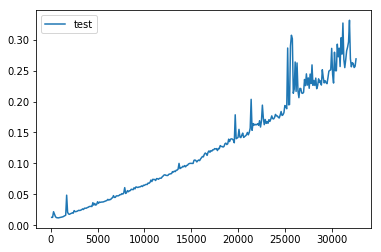

In [84]:
x, y = result
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(x, y, label="test")
# 凡例の表示
plt.legend()

# プロット表示(設定の反映)
plt.show()

# Evaluation function
def get_various_score(y_true, X_test, machine):
    for score in score_type:
        auc = machine.predict_proba(X_test)[:1]
        SCORE = roc_auc_score(y_true,y_pred)
        
        
        print(machine score_type)
            if score_type == 'auc':
        y_pred = pipeline.predict_proba(X_test)[:,1]
        score = roc_auc_score(y_true, y_pred)
    elif score_type == 'f1':
        y_pred = pipeline.predict(X_test)
        score = f1_score(y_true, y_pred)
    elif score_type == 'precision':
        y_pred = pipeline.predict(X_test)
        score = precision_score(y_true, y_pred)
    elif score_type == 'accuracy':
        y_pred = pipeline.predict(X_test)
        score = accuracy_score(y_true, y_pred)
    elif score_type == 'recall':
        y_pred = pipeline.predict(X_test)
        score = recall_score(y_true, y_pred)      
    else:
        score = None
    return score


from sklearn.metrics import r2_score
#check the r2 score
y_new_s = y_s.copy()
class_mapping = {'>50K':1,'<=50K':0}
y_new_s.loc[:,'Income'] = y_new_s['Income'].map(class_mapping)
predict_y_a = predict_y.iloc[:16281,:]

#check the shape
print(y_new_s.groupby(['Income']).size())
print('----------------------------------------------------------------------------------------')
print('y_new shape : (%i,%i)' %y_new.shape)
print('y_new_s shape: (%i,%i)'%y_new_s.shape)
print('predict_y_a shape(%i,%i)'%predict_y_a.shape)
print('Check the null count of the target variable: %i' % y.isnull().sum())

#y_new_s.join(predict_y_a).head(30)
score_fin = accuracy_score(y_new_s, predict_y_a)
print('accuracy_score is %.6f' %score_fin)

In [ ]:
#matplotの使い方のお勉強
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# データ生成
x = np.linspace(0, 10, 100)
y = x + np.random.randn(100) 
z = x +y
# プロット
plt.plot(x, y, label="test")

plt.plot(y, z, label='test2')

# 凡例の表示
plt.legend()

# プロット表示(設定の反映)
plt.show()
z